In [47]:
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
import seaborn as sns
from torchmetrics import MetricCollection, classification
from scipy.stats import friedmanchisquare


from Modules import PyTorch_Training, Fingerprint_Generator, My_Pytorch_Utilities

In [48]:
torch.manual_seed(42)

df_train = pd.read_csv('Transformed_Data/rega_train.csv')
df_test = pd.read_csv('Transformed_Data/rega_test.csv')

print(df_train.head(2))

              smiles  label
0  CN(C)C(=N)N=C(N)N      0
1   COC(=O)C=CC(=O)O      0


In [49]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [50]:
# Set the device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device: {torch.cuda.get_device_name(0)}")

DILI_model = PyTorch_Training.DILI_Models.DILI_Predictor_Sequential(2048, 512, 1).to(device)

Using cuda device: NVIDIA GeForce GTX 1070


In [51]:
metric_collection = MetricCollection([
    classification.Accuracy(task='binary', average='macro').to(device),  # Balanced accuracy
    classification.BinaryAUROC().to(device),
    classification.BinaryMatthewsCorrCoef().to(device)
    
    ])

In [52]:
from Modules import Fingerprint_Comparator

# regular_fingerprints = [
#     "maccs",
#     "avalon",
#     "ecfp",
# ]

regular_fingerprints = [
    "maccs",
    "avalon",
    "ecfp",
    "fcfp",
    "topological",
    "atompair",
    "rdkit",
    "pattern",
    "layered",
    "secfp",
]

df_train = pd.read_csv('Transformed_Data/rega_train.csv')

comparator = Fingerprint_Comparator.Pytorch_Train(df_train.iloc[:,0], df_train.iloc[:,1], DILI_model, 2048, metric_collection)

# comparator_results = comparator.regular_fingerprint(regular_fingerprints, pad=True, k_folds=10, epochs=10)

comparator_results, comparator_results_multiindex = comparator.regular_fingerprint(regular_fingerprints, pad=True, k_folds=10, epochs=10)

-------------------------------------------------------------maccs-------------------------------------------------------------
Fold 1 final results after 10 epochs: Train Acc: 0.388 Train Loss: 0.605 (n = 2109) | Test Acc: 0.729 Test Loss: 0.601 (n = 235) 
Fold 2 final results after 10 epochs: Train Acc: 0.148 Train Loss: 0.592 (n = 2109) | Test Acc: 0.741 Test Loss: 0.669 (n = 235) 
Fold 3 final results after 10 epochs: Train Acc: 0.319 Train Loss: 0.615 (n = 2109) | Test Acc: 0.726 Test Loss: 0.648 (n = 235) 
Fold 4 final results after 10 epochs: Train Acc: 0.721 Train Loss: 0.612 (n = 2109) | Test Acc: 0.685 Test Loss: 0.607 (n = 235) 
Fold 5 final results after 10 epochs: Train Acc: 0.224 Train Loss: 0.611 (n = 2110) | Test Acc: 0.329 Test Loss: 0.632 (n = 234) 
Fold 6 final results after 10 epochs: Train Acc: 0.214 Train Loss: 0.611 (n = 2110) | Test Acc: 0.723 Test Loss: 0.648 (n = 234) 
Fold 7 final results after 10 epochs: Train Acc: 0.345 Train Loss: 0.615 (n = 2110) | Test A

In [53]:
print(comparator_results)

   Fingerprint  Fold  test_BinaryAccuracy  test_BinaryAUROC  \
0        maccs     0                0.729             0.319   
0        maccs     1                0.741             0.363   
0        maccs     2                0.726             0.329   
0        maccs     3                0.685             0.685   
0        maccs     4                0.329             0.726   
..         ...   ...                  ...               ...   
0        secfp     5                0.697             0.752   
0        secfp     6                0.571             0.735   
0        secfp     7                0.574             0.705   
0        secfp     8                0.576             0.709   
0        secfp     9                0.570             0.744   

    test_BinaryMatthewsCorrCoef  
0                         0.702  
0                         0.570  
0                         0.664  
0                         0.317  
0                         0.632  
..                          ...  
0    

<Axes: xlabel='Fingerprint', ylabel='test_BinaryAccuracy'>

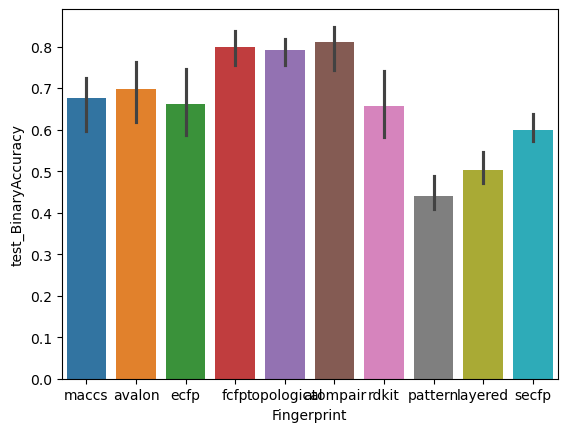

In [57]:
mean_score = comparator_results.iloc[:,2].mean()  # Mean of entire column

comparator_results_means = comparator_results.iloc[:,2] - mean_score
comparator_results_means = comparator_results_means.sort_values(ascending=False)

sns.barplot(
    data = comparator_results,
    x='Fingerprint',
    y='test_BinaryAccuracy',
    hue="Fingerprint",
)

In [56]:
list_of_scores = []

for fingerprint in regular_fingerprints:
    fp_and_acc = comparator_results.filter(["Fingerprint", "test_BinaryAccuracy"], axis=1)
    fp_and_acc = (fp_and_acc.query('Fingerprint == @fingerprint'))
    list_of_scores.append(fp_and_acc)


friedman_stat, friedman_p = friedmanchisquare(*[list_of_scores[x].iloc[:, 1] for x in range(len(list_of_scores))])
print(friedman_p)

9.058487269161868e-08


In [ ]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    train_metrics = metric_collection.clone(prefix="train_")
    train_loss, train_accuracy = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        predicted_y = model0(X)
        predicted_y = predicted_y.squeeze(1)

        loss = loss_fn(predicted_y, y)
        train_loss += loss.item()
        train_metrics_results = train_metrics(predicted_y, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_metrics_results = train_metrics.compute()
    train_metrics.reset()
    
    train_loss = train_loss / len(dataloader)

    return train_loss, train_metrics_results #, predicted_y, y

In [ ]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    model.eval()
    test_metrics = metric_collection.clone(prefix="test_")
    test_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_predicted_y = model0(X)
            test_predicted_y = test_predicted_y.squeeze(1)
            # print(test_predicted_y.shape); print(y.shape)#  Uncomment to confirm shape

            loss = loss_fn(test_predicted_y, y)
            test_loss += loss.item()
            
            test_metrics_results = test_metrics(test_predicted_y, y)
        
        test_metrics_results = test_metrics.compute()
        test_metrics.reset()

    test_loss = test_loss / len(dataloader)
    
    return test_loss, test_metrics_results

In [ ]:
def metics_tensor_dict_to_floats(metrics):
    return {key: value.to(device='cpu', non_blocking=True).item() if hasattr(value, 'to') 
else value for key, value in metrics.items()}

In [ ]:
from sklearn.model_selection import StratifiedKFold


def train(model: torch.nn.Module, dataset: torch.utils.data.Dataset, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module = nn.BCELoss(), epochs: int = 10, k_folds: int = 5, batch_size: int = 256, DP:int = 3):
    kfold = StratifiedKFold(k_folds, shuffle=True, random_state=42)
    score_df = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset, dataset.labels)): 
        loss = {"train_loss": [], "test_loss": []}
        
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)
        
        reset_weights(model)

        for epoch in range(epochs):
            # tracker.increment()
            train_loss, train_metrics = train_step(model=model, dataloader=train_loader, loss_fn=loss_fn, optimizer=optimizer)
            # tracker.update(predicted_y, y)
            test_loss, test_metrics = test_step(model=model, dataloader=test_loader, loss_fn=loss_fn)

            train_metrics, test_metrics = metics_tensor_dict_to_floats(train_metrics), metics_tensor_dict_to_floats(test_metrics)
            loss["train_loss"].append(train_loss)
            loss["test_loss"].append(test_loss)
            
            if EarlyStopper().early_stop(test_loss):
                break

        score_df.append(pd.DataFrame.from_dict(test_metrics, orient="index").transpose().round(DP))
        
        print(f"Fold {fold+1} final results after {epoch+1} epochs: Train Acc: {train_metrics['train_BinaryAccuracy']:.{DP}f} Train Loss: {train_loss:.{DP}f} (n = {len(train_idx)}) | Test Acc: {test_metrics['test_BinaryAccuracy']:.{DP}f} Test Loss: {test_loss:.{DP}f} (n = {len(test_idx)}) ")

    score_df = pd.concat(score_df)
    score_df.insert(0, "Fold", range(k_folds))
    score_df.set_index("Fold", inplace=True)
    
    return loss, score_df #, tracker.compute_all()

In [ ]:
# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=1e-4)

reset_weights(model0)
model0_loss, model0_df = train(model=model0, dataset=dilidataset, optimizer=optimizer, loss_fn=loss_fn, epochs=1, k_folds=2, batch_size=256)

In [ ]:
from Modules import PyTorch_Training

PyTorch_Training.Model_Train_Test(model0, metric_collection, loss_fn=loss_fn).train_model(dilidataset, epochs=2)

In [ ]:
regular_fingerprints = [
    "ecfp",
    "ecfp-count",
    "fcfp"
]
df_train = pd.read_csv('Transformed_Data/rega_train.csv')

fp_df = []



for fingerprint in regular_fingerprints:
    df_train = pd.read_csv('Transformed_Data/rega_train.csv')
    df_train = Fingerprint_Generator.generate_fp_column(df_train, df_train.smiles, fp_type=fingerprint)
    df_train = df_train.drop("smiles", axis=1)
    
    DILIfeatures = df_train.iloc[:, 1]
    DILIlabels = df_train.iloc[:, 0]
    
    dilidataset = DILIDataset(DILIfeatures, DILIlabels)
    
    
    loss, score_df = train(model=model0, dataset=dilidataset, optimizer=optimizer, loss_fn=loss_fn, epochs=10, k_folds=5, batch_size=256)
    
    fp_df.append(score_df)

In [ ]:
import matplotlib.pyplot as plt


def plot_loss_curve(results: dict[str, list[float]]):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Plot loss
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    
    plt.title("Loss vs Epochs")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curve(model0_loss)

In [ ]:
# from Modules import My_Pytorch_Utilities

# dummy_data = torch.rand([1, 2048])

# dummy_data.shape

# My_Pytorch_Utilities.save(model0, "DILIst", dummy_data.to(device))

In [ ]:
from Modules import PyTorch_Pretrained_Inference

validation_smiles = ["CCC", "CCCC", "Fc1ccc(cc1)[C@@]3(OCc2cc(C#N)ccc23)CCCN(C)C"]
validation_smiles_labels = [1, 0, 1]

regular_fingerprints = [
    "ecfp",
    "fcfp",
    "secfp",
]

PyTorch_Pretrained_Inference.DILI_Inference(validation_smiles, model0).regular_fingerprint(regular_fingerprints)

In [ ]:
from Modules import Fingerprint_Comparator

Fingerprint_Comparator.PyTorch_Pretrained(validation_smiles, validation_smiles_labels, model0).regular_fingerprint(regular_fingerprints, 2048)

In [ ]:
# ## Assuming you have loaded_model and device available

# from Modules import Fingerprint_Generator

# validation_smiles = ["CCC", "CCCC", "Fc1ccc(cc1)[C@@]3(OCc2cc(C#N)ccc23)CCCN(C)C"]

# def evaluate_smiles(model, input_smiles):
#     scores = {}
#     validation_fp = Fingerprint_Generator.Smiles_To_Fingerprint(input_smiles, fingerprint).astype(torch.Tensor).squeeze(1).to(device)
#     with torch.no_grad():
#         model0.eval()
#         for i, input in enumerate(validation_fp):
#             output = model(input)
#             scores.update({round(output.item(), 3): validation_smiles[i]})
#             # scores.append(output.item())
#         return scores

# print(evaluate_smiles(model0, validation_smiles))


# # print(f"Prediction for {validation_smiles}: {prediction:.3f}")